# Neural Amp Modeler (Trainer)
This notebook allows you to train a neural amp model based on a pair of input/output WAV files that you have of the amp you want to model.

**To use this notebook**:
Go to [colab.research.google.com](https://colab.research.google.com/), select the "GitHub" tab, and select this notebook. Or, if you've cloned the repo, you can upload it from your computer.

🔶**Before you run**🔶

Make sure to get a GPU! (Runtime->Change runtime type->Select "GPU" from the "Hardware accelerator dropdown menu)

⚠**Warning**⚠

Google Colab GPU instances only last for 12 hours.
Plan your training accordingly!

## Steps:
0. Install everything
1. Upload audio files
2. Settings
3. Run!
4. Check
5. Export
6. Download your files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 0: Install
Install `nam` and the other Python packages it depends on.

In [ ]:
!pip install git+https://github.com/KirillDeLutherSergeev/neural-amp-modeler.git@main

In [ ]:
from time import time
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from google.colab import files
from torch.utils.data import DataLoader

from nam.data import Split, init_dataset
from nam.models import Model

import wavio

## Step 1: Upload audio files
Upload the input (DI) and output (amped) files you want to use.

You'll need two pairs of files (4 in total):
* A training pair (`x_train.wav`, `y_train.wav`) for the model to fit to.
* A validation pair, (`x_validation.wav`, `y_validation.wav`) to check the model's performance on a new signal.

The **default names** for the training data are `x_train.wav` (DI input) and `y_train.wav` (amped output), and for the validation set, `x_validation.wav` and `y_validation.wav`. 

If you files are named differently, don't worry--you can modify the names in the data config below.

In [ ]:
uploaded = files.upload()

## Step 2: Settings
The defaults are what I tend to start with and should usually work well (except the file names--see above), but if you'd like, you can make changes.

🔶**Important**🔶

If there is a **delay** between your input and output (e.g. if you reamped and your interface has latency that your DAW doesn't factor out), then change that in the `data_config` dict below to the delay, in samples. For example, if the output lags the input by 505 samples, then change it to `"delay": 505`. If there's too much delay (e.g. more than 10 samples), then the model may not learn. The closer you get this, the better the results will be, but don't over-compensate or else the model would have to predict the future!

In [ ]:
data_config = {
    "train": {
        "x_path": "drive/MyDrive/ML/5153B/x_train.wav",
        "y_path": "drive/MyDrive/ML/5153B/y_train.wav",
        "ny": 32768
    },
    "validation": {
        "x_path": "drive/MyDrive/ML/5153B/x_validation.wav",
        "y_path": "drive/MyDrive/ML/5153B/y_validation.wav",
        "ny": None
    },
    "common": {
        "delay": 0
    }
}
model_config = {
    "net": {
        "name": "LSTM",
        "config": {
            "num_layers": 3,
            "hidden_size": 48,
            "train_burn_in": 4096,
            "train_truncate": 512            
        }
    },
    "loss": {
        "val_loss": "mse",
        "mask_first": 4096,    
        "pre_emph_weight": 1.0,
        "pre_emph_coef": 0.85
    },
    "optimizer": {
        "lr": 0.01
    },
    "lr_scheduler": {
        "class": "ExponentialLR",
        "kwargs": {
            "gamma": 0.995
        }
    }
}
learning_config = {
    "train_dataloader": {
        "batch_size": 32,
        "shuffle": True,
        "pin_memory": True,
        "drop_last": True,
        "num_workers": 0
    },
    "val_dataloader": {},
    "trainer": {
        "gpus": 1,
        "max_epochs": 100
    },
    "trainer_fit_kwargs": {}
}

## Step 3: Run!
Let's rock

In [ ]:
model = Model.init_from_config(model_config)

In [ ]:
data_config["common"]["nx"] = model.net.receptive_field

In [ ]:
dataset_train = init_dataset(data_config, Split.TRAIN)
dataset_validation = init_dataset(data_config, Split.VALIDATION)
train_dataloader = DataLoader(dataset_train, **learning_config["train_dataloader"])
val_dataloader = DataLoader(dataset_validation, **learning_config["val_dataloader"])

In [ ]:
trainer = pl.Trainer(
    callbacks=[
        pl.callbacks.model_checkpoint.ModelCheckpoint(
            filename="{epoch:04d}_{step}_{ESR:.3e}_{MSE:.3e}",
            save_top_k=3,
            monitor="val_loss",
            every_n_epochs=1,
        ),
        pl.callbacks.model_checkpoint.ModelCheckpoint(
            filename="checkpoint_last_{epoch:04d}_{step}", every_n_epochs=1
        ),
    ],
    **learning_config["trainer"],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Here we go!
trainer.fit(
    model,
    train_dataloader,
    val_dataloader,
    **learning_config.get("trainer_fit_kwargs", {}),
)
# Monitor the progress in lightning_logs/version_0/checkpoints.
# Tthe ESR may plateau at 1 for about 20 iterations, but if it hasn't started decreasing
# By then, then something might be wrong e.g. mismatched data, or an incorrect delay 
# (see above).
#
# Many models can get a good result (rule of thumb: look for ESR<0.01) in about 15 
# minutes of training, but if you're more patient, it'll probably keep getting better.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type | Params
------------------------------
0 | _net | LSTM | 47.8 K
------------------------------
47.8 K    Trainable params
0         Non-trainable params
47.8 K    Total params
0.191     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# Go to best checkpoint
best_checkpoint = trainer.checkpoint_callback.best_model_path
if best_checkpoint != "":
    model = Model.load_from_checkpoint(
        trainer.checkpoint_callback.best_model_path,
        **Model.parse_config(model_config),
    )
model.eval()

Model(
  (_net): LSTM(
    (_core): _L(1, 48, num_layers=3, batch_first=True)
    (_head): Linear(in_features=48, out_features=1, bias=True)
  )
)

# Step 4: Check
Let's look at how well our model matches the real thing.

In [ ]:
from nam.models.conv_net import REQUIRED_RATE
def _rms(x: Union[np.ndarray, torch.Tensor]) -> float:
    if isinstance(x, np.ndarray):
        return np.sqrt(np.mean(np.square(x)))
    elif isinstance(x, torch.Tensor):
        return torch.sqrt(torch.mean(torch.square(x))).item()
    else:
        raise TypeError(type(x))

def plot(
    model,
    ds,
    savefig=None,
    show=True,
    window_start: Optional[int] = None,
    window_end: Optional[int] = None,
):
    with torch.no_grad():
        tx = len(ds.x) / REQUIRED_RATE
        print(f"Run (t={tx})")
        t0 = time()
        output = model(ds.x).flatten().cpu().numpy()
        t1 = time()
        print(f"Took {t1 - t0} ({tx / (t1 - t0):.2f}x)")
        wavio.write(
        str("test_output.wav"),
        output,
        REQUIRED_RATE,
        sampwidth=4,
        )
        
    plt.figure(figsize=(16, 5))
    # plt.plot(ds.x[window_start:window_end], label="Input")
    plt.plot(output[window_start:window_end], label="Prediction")
    plt.plot(ds.y[window_start:window_end], linestyle="--", label="Target")
    # plt.plot(
    #     ds.y[window_start:window_end] - output[window_start:window_end], label="Error"
    # )
    plt.title(f"NRMSE={100.0 * _rms(torch.Tensor(output) - ds.y) / _rms(ds.y):2.1f}%")
    plt.legend()
    if savefig is not None:
        plt.savefig(savefig)
    if show:
        plt.show()

Run (t=22.460204081632654)
Took 68.26602172851562 (0.33x)


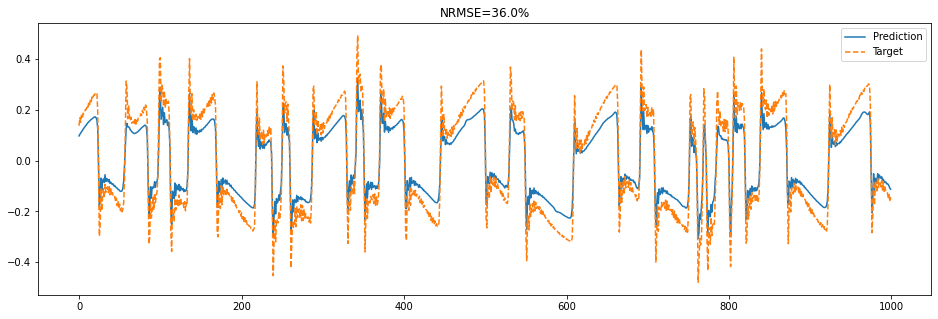

In [ ]:
plot(
    model,
    dataset_validation,
    window_start=100_000,  # Start of the plotting window, in samples
    window_end=101_000,  # End of the plotting window, in samples
)
# Don't worry if the LSTM runs slower than 1x. Python's interpreter is slow, and the C++
# version is a lot faster.

## Step 5: Export your model
Now we'll use NAM's exporting utility to convert the model from its PyTorch representation to something that you can put into the plugin.

In [ ]:
# This isn't used right now, but I might use it in the future :)
# model.export(".")

model.net.export_cpp_header("HardCodedModel.h")

## Step 6: Download your artifacts
We're done! 
Go to the file browser on the left panel ⬅ and collect your artifacts!

Be sure to download the lightning model artifacts (in case you want to continue training later) and your exported model (so that you can put it into a plugin).

In [ ]:
model.net.export(".")

In [ ]:
def calculate(
    model,
    ds
):
    with torch.no_grad():
        tx = len(ds.x) / REQUIRED_RATE
        print(f"Run (t={tx})")
        t0 = time()
        output = model(ds.x).flatten().cpu().numpy()
        t1 = time()
        print(f"Took {t1 - t0} ({tx / (t1 - t0):.2f}x)")
        wavio.write(
        str("test_output.wav"),
        output,
        REQUIRED_RATE,
        sampwidth=4,
        )

In [ ]:
calculate(model,dataset_validation)

Run (t=22.460204081632654)
Took 64.20673418045044 (0.35x)
